<a href="https://colab.research.google.com/github/Aryan8912/Multi-agent_reinforcement_learning_DDPG/blob/main/Multi_agent_reinforcement_learning_DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchrl
!pip install vmas
!pip install pettingzoo[mpe]==1.24.3
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.4/211.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.8 MB/s eta 0:00:00
  Created wheel for vmas: filename=vmas-1.4.3-py3-none-any.whl size=251650 sha256=84d8e174df96763fe505fe18c78dea452dcad668ef70464cd953bfd1c1c6fffd
  Stored in directory: /root/.cache/pip/wheels/59/26/e7/4cea32dc0e5c830808affe26bfd854dc4fd6075939c46ba4f0
Successfully built vmas
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 58.7 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfu

In [2]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

# Check if we're building the doc, in which case disable video rendering
try:
    is_sphinx = __sphinx_build__
except NameError:
    is_sphinx = False

In [3]:
# Seed
seed = 0
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() =="fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

# Sampling
frames_per_batch = 1_000 # Number of team frames collected per sampling iteration
n_iters = 10 # Number of sampling and traning iterations
total_frames = frames_per_batch * n_iters

# We will stop training the evaders after this many iteration,
# should be 0 <= iteration_when_stop_training_evaders <= n_iters
iteration_when_stop_training_evadrs = n_iters // 2

# Replay buffer
memory_size = 1_000_000 # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100 # Number of optimization steps per training iteration
train_batch_size = 128 # Number of frames trained in each optimiser step
lr = 3e-4 # Learning rate
max_grad_norm = 1.0 # Maximum norm for the gradients

# DDPG
gamma = 0.99 # Discount factor
polyak_tau = 0.005 # Tau for the soft-update of the target network

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
max_steps = 100 # Environment steps before done
n_chasers = 2
n_evaders = 1
n_obstacles = 2

use_vmas = True # set this to true for a greate performance speedup
if not use_vmas:
  base_env = pettingZooEnv(
      task="simple_tag_v3",
      parallel=True, # Use the parallel version
      seed=seed,
      # Scenario specific
      continous_actions=True,
      num_good=n_evaders,
      num_adversaries=n_chasers,
      num_obstacles=n_obstacles,
      max_cycles=max_steps,
  )
else:
  num_vmas_envs = (
      frames_per_batch // max_steps
  ) # Number of vectorized environments. frames_per_batch collection will be divided among these environments
  base_env = VmasEnv(
      scenario="simple_tag",
      num_envs=num_vmas_envs,
      max_cycles=max_steps,
      device=device,
      seed=seed,
      # Scenario specific
      num_good_agents = n_evaders,
      num_adversaries = n_chasers,
      num_obstacles = n_obstacles,
  )

/usr/local/lib/python3.10/dist-packages/vmas/simulator/utils.py:317: UserWarning: Scenario kwargs: {'max_cycles': 100, 'num_obstacles': 2} passed but not used by the scenario. This will turn into an error in future versions.
  warnings.warn(


In [5]:
print(f"group_map: {base_env.group_map}")

group_map: {'adversary': ['adversary_0', 'adversary_1'], 'agent': ['agent_0']}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)

action_spec: Composite(
    adversary: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 2, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([10, 2])),
    agent: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cu

In [7]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)

action_keys: [('adversary', 'action'), ('agent', 'action')]
reward_keys: [('adversary', 'reward'), ('agent', 'reward')]
done_keys: ['done', 'terminated']


In [8]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys = base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    )
)

In [9]:
check_env_specs(env)

2025-01-10 07:58:33,451 [torchrl][INFO] check_env_specs succeeded!


In [10]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 2, 14]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 5, 2]),
            device=cuda:0,
            is_shared=True),
        agent: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 1, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 1, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 1, 12]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_si

In [11]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = True  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

In [12]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec[group, "action"].space.low,
            "high": env.full_action_spec[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy

In [13]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy

In [15]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence

In [16]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
  print(
      f"Running value and policy for group '{group}':",
      critics[group](policies[group](reset_td)),
  )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Running value and policy for group 'adversary': TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                obs_action: Tensor(shape=torch.Size([10, 2, 16]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 2, 14]), device=cuda:0, dtype=torch.float32, is_shared=True),
                param: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                state_action_value: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 2]),
            device=cuda:0,
            is_shared=True),
        agent: TensorDict(
            fields={
            

In [17]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(
            memory_size, device="cpu" # Force device to be "cpu"
        ),  # We will store up to memory_size multi-agent transitions
        sampler=RandomSampler(),
        batch_size=train_batch_size,  # We will sample batches of this size
    )
    replay_buffers[group] = replay_buffer

In [21]:
losses = {}
for group, _agents in env.group_map.items():
    loss_module = DDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
train_group_map = copy.deepcopy(env.group_map)

# Training/collection iterations
for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)  # Util to expand done keys if needed
    # Loop over groups
    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )  # Exclude data from other groups
        group_batch = group_batch.reshape(
            -1
        )  # This just affects the leading dimensions in batch_size of the tensordict
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()

            # Move subdata to the device where the model is located
            subdata = subdata.to(device)

            loss_vals = losses[group](subdata)

            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]

                loss.backward()

                # Optional
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)

                optimiser.step()
                optimiser.zero_grad()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames)

    # Stop training a certain group when a condition is met (e.g., number of training iterations)
    if iteration == iteration_when_stop_training_evaders:
        del train_group_map["agent"]

    # Logging
    # ... (rest of your code remains the same)
    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()


episode_reward_mean_adversary = 0, episode_reward_mean_agent = 0:   0%|          | 0/10 [02:30<?, ?it/s]


NameError: name 'iteration_when_stop_training_evaders' is not defined

NameError: name 'iteration_when_stop_training_evaders' is not defined

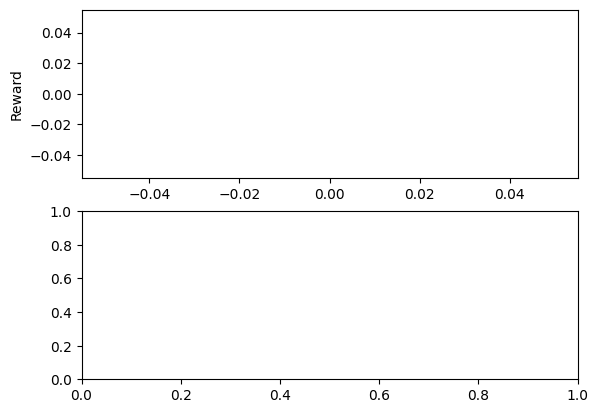

In [24]:
fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].axvline(
        x=iteration_when_stop_training_evaders,
        label="Agent (evader) stop training",
        color="orange",
    )
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()

In [25]:
if use_vmas and not is_sphinx:
    # Replace tmpdir with any desired path where the video should be saved
    with tempfile.TemporaryDirectory() as tmpdir:
        video_logger = CSVLogger("vmas_logs", tmpdir, video_format="mp4")
        print("Creating rendering env")
        env_with_render = TransformedEnv(env.base_env, env.transform.clone())
        env_with_render = env_with_render.append_transform(
            PixelRenderTransform(
                out_keys=["pixels"],
                # the np.ndarray has a negative stride and needs to be copied before being cast to a tensor
                preproc=lambda x: x.copy(),
                as_non_tensor=True,
                # asking for array rather than on-screen rendering
                mode="rgb_array",
            )
        )
        env_with_render = env_with_render.append_transform(
            VideoRecorder(logger=video_logger, tag="vmas_rendered")
        )
        with set_exploration_type(ExplorationType.DETERMINISTIC):
            print("Rendering rollout...")
            env_with_render.rollout(100, policy=agents_exploration_policy)
        print("Saving the video...")
        env_with_render.transform.dump()
        print("Saved! Saved directory tree:")
        video_logger.print_log_dir()

Creating rendering env
Rendering rollout...


ImportError: Error occurred while running `from pyglet.gl import *`, HINT: make sure you have OpenGL installed. On Ubuntu, you can run 'apt-get install python3-opengl'. If you're running on a server, you may need a virtual frame buffer; something like this should work:'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'